# Modelos de Crescimento Econômico: **Modelo de Solow com a PWT** 

## Bibliotecas

In [ ]:
## Importando o que for necessário
# Manipulação de dados
import pandas as pd
import numpy as np

# Testes e Regressões
from scipy import stats
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from patsy import dmatrices

# Gráficos
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import clear_output # limpa o output de uma célula

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Penn World Table

Link de acesso: https://www.rug.nl/ggdc/productivity/pwt/?lang=en


In [ ]:
## Lendo os dados
sCaminho = "/content/drive/MyDrive/Projetos/IDP/MBA/SetorPublicoIII/Códigos/Aula 3 - 07_12_2021/"
sArquivo = "pwt100.dta"

## Lendo o DataFrame
data = pd.read_stata(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {data.shape[0]}; Colunas: {data.shape[1]}")

Linhas: 12810; Colunas: 52


In [ ]:
## Vendo o DataFrame
data.head(10)

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,ccon,cda,cgdpe,cgdpo,cn,ck,ctfp,cwtfp,rgdpna,rconna,rdana,rnna,rkna,rtfpna,rwtfpna,labsh,irr,delta,xr,pl_con,pl_da,pl_gdpo,i_cig,i_xm,i_xr,i_outlier,i_irr,cor_exp,statcap,csh_c,csh_i,csh_g,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,Aruban Guilder,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,Aruban Guilder,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,Aruban Guilder,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,Aruban Guilder,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,Aruban Guilder,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ABW,Aruba,Aruban Guilder,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ABW,Aruba,Aruban Guilder,1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ABW,Aruba,Aruban Guilder,1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,ABW,Aruba,Aruban Guilder,1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,ABW,Aruba,Aruban Guilder,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Vendo a descrição das variáveis (só funciona com arquivos .dta)
# Lendo novamente a base, mas agora com iterator, o que retorna um objeto do tipo StataReader
stata_reader = pd.read_stata(f"{sCaminho}{sArquivo}", iterator=True)

# Pegando as descrições das variáveis
descricoes = stata_reader.variable_labels()
descricoes

{'avh': 'Average annual hours worked by persons engaged (source: The Conference Board)',
 'ccon': 'Real consumption of households and government, at current PPPs (in mil. 2017US$)',
 'cda': 'Real domestic absorption, see note cda',
 'cgdpe': 'Expenditure-side real GDP at current PPPs (in mil. 2017US$)',
 'cgdpo': 'Output-side real GDP at current PPPs (in mil. 2017US$)',
 'ck': 'Capital services levels at current PPPs (USA=1)',
 'cn': 'Capital stock at current PPPs (in mil. 2017US$)',
 'cor_exp': 'Correlation between expenditure shares, see note cor_exp',
 'country': 'Country name',
 'countrycode': '3-letter ISO country code',
 'csh_c': 'Share of household consumption at current PPPs',
 'csh_g': 'Share of government consumption at current PPPs',
 'csh_i': 'Share of gross capital formation at current PPPs',
 'csh_m': 'Share of merchandise imports at current PPPs',
 'csh_r': 'Share of residual trade and GDP statistical discrepancy at current PPPs',
 'csh_x': 'Share of merchandise exports 

Vamos calcular o modelo de solow entre os anos de 1960 e 1985 (mesmo período da aula passada). Para isso, vamos precisar fazer algumas modificações nos nossos dados.

## Manipulação de Dados

Variáveis de interesse:

- PIB por trabalhador = *rgdpo/emp*;
- PIB = *rgdpo* (usado para calcular $g$);
- Empregados (milhões) = *emp* (usado para calcular a taxa de crescimento $\mu$);
- Taxa de Poupança (lembrem-se, em economia, poupança (interna + externa) = investimento) = *csh_i*;
- Taxa de depreciação = *delta*;
- *Proxy* para capital humano (*human capital*): *hc*.

Observações:

1. Usaremos o *rgdpo* por ele estar ajustado pela paridade do poder de compra e em valores reais (milhões de dólares de 2017).

2. *hc* é um índice que leva em conta os anos médios de educação e os retornos obtidos por eles nos salários.

### Criação de Variáveis e Exclusão de Dados Faltantes

In [ ]:
## Definindo os anos
nAno1 = 1960
nAno2 = 1985

In [ ]:
## Copiando o dataframe original com os dados entre 1960 e 1985
dataSolow = data.query(f"year >= {nAno1} & year <= {nAno2}").copy()

## Criando o PIB por trabalhador
dataSolow["rgdpo_emp"] = dataSolow["rgdpo"] / dataSolow['emp']

## E deixar apenas as variáveis de interesse
dataSolow = dataSolow[["country", "year", "rgdpo", "emp", "rgdpo_emp", "csh_i", "hc", "delta"]]

# Vendo o tamanho da base
print(f"Linhas: {dataSolow.shape[0]}; Colunas: {dataSolow.shape[1]}")

## Vendo uma amostra (sample) de 5 dados aleatórios
dataSolow.sample(n=5)

Linhas: 4758; Colunas: 8


,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta
1663,Bolivia (Plurinational State of),2003,31589.179688,3.720909,8489.641602,0.112298,2.573074,0.054779
11586,Trinidad and Tobago,1986,18877.406250,0.390500,48341.625000,0.117059,2.462799,0.049236
1175,Bulgaria,2005,100854.507812,3.154664,31969.964844,0.208800,2.990984,0.057781
11251,Chad,2001,9408.649414,3.395329,2771.056396,0.185738,NaN,0.034063
2993,Curaçao,2003,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Há alguns países sem observações para alguns anos
## Para contornar esse problema, vamos usar apenas países com dados completos

## Contando NaNs
# Obs: especificamos o dataSolow["country"] no groupby porque estamos selecionando apenas uma variável específica (sVariavel)
# Em groupbys sem o transform, não precisaríamos disso, podendo apenas especificar "country"
for sVariavel in ["rgdpo", "emp", "csh_i", "hc", "delta"]:
  dataSolow[f"nans_{sVariavel}"] = dataSolow[f"{sVariavel}"].isnull().groupby(dataSolow["country"]).transform('sum')

# Vendo resultado
dataSolow

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,nans_rgdpo,nans_emp,nans_csh_i,nans_hc,nans_delta
35,Aruba,1985,1692.186523,NaN,NaN,0.357274,NaN,0.035724,0,6,0,26,0
36,Aruba,1986,1848.224731,NaN,NaN,0.364344,NaN,0.035728,0,6,0,26,0
37,Aruba,1987,2143.880615,NaN,NaN,0.353578,NaN,0.035786,0,6,0,26,0
38,Aruba,1988,2543.252930,NaN,NaN,0.351074,NaN,0.035937,0,6,0,26,0
39,Aruba,1989,2657.243652,NaN,NaN,0.376601,NaN,0.036049,0,6,0,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12796,Zimbabwe,2006,16519.853516,5.504240,3001.296143,0.192624,2.279855,0.038153,0,0,0,0,0
12797,Zimbabwe,2007,18695.630859,5.554227,3366.018555,0.142579,2.302697,0.037221,0,0,0,0,0
12798,Zimbabwe,2008,14817.710938,5.624591,2634.451416,0.142007,2.325768,0.036484,0,0,0,0,0
12799,Zimbabwe,2009,26465.283203,5.681129,4658.455078,0.115220,2.349070,0.036915,0,0,0,0,0


In [ ]:
## Somando os nans
dataSolow["nans"] = np.sum(dataSolow[["nans_rgdpo", "nans_emp", "nans_csh_i", "nans_hc", "nans_delta"]], axis=1)
dataSolow

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,nans_rgdpo,nans_emp,nans_csh_i,nans_hc,nans_delta,nans
35,Aruba,1985,1692.186523,NaN,NaN,0.357274,NaN,0.035724,0,6,0,26,0,32
36,Aruba,1986,1848.224731,NaN,NaN,0.364344,NaN,0.035728,0,6,0,26,0,32
37,Aruba,1987,2143.880615,NaN,NaN,0.353578,NaN,0.035786,0,6,0,26,0,32
38,Aruba,1988,2543.252930,NaN,NaN,0.351074,NaN,0.035937,0,6,0,26,0,32
39,Aruba,1989,2657.243652,NaN,NaN,0.376601,NaN,0.036049,0,6,0,26,0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12796,Zimbabwe,2006,16519.853516,5.504240,3001.296143,0.192624,2.279855,0.038153,0,0,0,0,0,0
12797,Zimbabwe,2007,18695.630859,5.554227,3366.018555,0.142579,2.302697,0.037221,0,0,0,0,0,0
12798,Zimbabwe,2008,14817.710938,5.624591,2634.451416,0.142007,2.325768,0.036484,0,0,0,0,0,0
12799,Zimbabwe,2009,26465.283203,5.681129,4658.455078,0.115220,2.349070,0.036915,0,0,0,0,0,0


In [ ]:
## Retirando observações com ao menos 1 nan
dataSolow.query("nans == 0", inplace=True)

## Selecionando (novamente) apenas as colunas de interesse
## E deixar apenas as variáveis de interesse
dataSolow = dataSolow[["country", "year", "rgdpo", "emp", "rgdpo_emp", "csh_i", "hc", "delta"]].copy()

# Vendo o tamanho da base
print(f"Linhas: {dataSolow.shape[0]}; Colunas: {dataSolow.shape[1]}")

Linhas: 3328; Colunas: 8


### Calculando Médias

Para estimarmos o modelo de Solow de forma mais acurada, precisamos pegar as médias dos dados dos países ao longo do tempo.

Note que até poderíamos pegar os dados de apenas um ano, mas isso nos deixaria expostos a variações pontuais de alguns países, enquanto as médias ajudam a pegar melhor as tendências.

#### Médias Simples

No caso da taxa de investimento, taxa de depreciação e capital humano, podemos tirar médias simples dos países.

Por que? As taxas já estão em %, enquanto *hc* é um índice.

In [ ]:
## Calculando as médias e adicionando como coluna ao DataFrame usando transform
# Novamente, por estarmos selecionando a coluna antes do groupby, temos que especificar
# dataSolow["country"], e não apenas "country"
dataSolow[f"csh_i_media"] = dataSolow["csh_i"].groupby(dataSolow["country"]).transform('mean')
dataSolow[f"delta_media"] = dataSolow["delta"].groupby(dataSolow["country"]).transform('mean')
dataSolow[f"hc_media"] = dataSolow["hc"].groupby(dataSolow["country"]).transform('mean')

# Vendo resultado
dataSolow.head(25)

# Veja como, por exemplo, o csh_i de Angola é muito volátil, o que prejudicaria nossos resultados
# se usássemos apenas um anos

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,csh_i_media,delta_media,hc_media
105,Angola,1985,32966.546875,5.760098,5723.261230,0.258170,1.088488,0.033066,0.376463,0.037049,1.251455
106,Angola,1986,29358.679688,5.935183,4946.550293,0.246006,1.098228,0.032605,0.376463,0.037049,1.251455
107,Angola,1987,32969.546875,6.114353,5392.156250,0.248240,1.108056,0.032179,0.376463,0.037049,1.251455
108,Angola,1988,31056.705078,6.296732,4932.193848,0.196775,1.117972,0.031836,0.376463,0.037049,1.251455
109,Angola,1989,33118.722656,6.481249,5109.928711,0.167627,1.127977,0.031557,0.376463,0.037049,1.251455
110,Angola,1990,35987.328125,6.667242,5397.633301,0.162812,1.138071,0.031356,0.376463,0.037049,1.251455
111,Angola,1991,33312.191406,6.864369,4852.913574,0.421966,1.153040,0.031506,0.376463,0.037049,1.251455
112,Angola,1992,38985.789062,7.066923,5516.657227,0.526537,1.168206,0.032033,0.376463,0.037049,1.251455
113,Angola,1993,33555.558594,7.271165,4614.880859,0.500108,1.183572,0.032518,0.376463,0.037049,1.251455
114,Angola,1994,35790.539062,7.466424,4793.531738,0.454813,1.199139,0.032884,0.376463,0.037049,1.251455


#### Taxas de Crescimento Geométricas

Para calcular as taxas médias de crescimento do PIB e da força de trabalho, não podemos usar médias simples, uma vez que estamos interessados em porcentagens.

Para isso, precisaremos usar a taxa média de crescimento geométrica (TMCGA para os íntimos.)

Apesar do nome, ela é bem fácil de ser calculada. Sendo $t_1$ e $t_2$ os períodos e $x$ a variável de interesse,

\begin{align*}
TMGCA = \sqrt[t_2 - t_1]{\frac{x_{t_2}}{x_{t_1}}} - 1
\end{align*}

Rearranjando a equação, podemos encontrar algo que seja mais intuitivo:

\begin{align*}
x_{t_2} = (1 + TMGCA)^{(t_2 - t_1)} \cdot x_{t_1}
\end{align*}

Alternativamente,

\begin{align*}
x_{t_1} =  \frac{x_{t_2}}{(1 + TMGCA)^{(t_2 - t_1)}}
\end{align*}

In [ ]:
## Agora que já calculamos as médias simples, podemos usar apenas os dados de 1960 e 1985
dataSolow9015 = dataSolow.query(f"year == {nAno1} | year == {nAno2}").copy()

Usaremos a função `pct_change()` do `pandas`, que nos fornece $\frac{x_{t_2}}{x_{t_1}} - 1$. Assim, basta somar 1, tirar a raíz 25ª (1985 - 1960) e subtrair 1 novamente. 



In [ ]:
## Criando a coluna de variação percentual do PIB e da população
dataSolow9015["cresc_rgdpo_medio"] = (dataSolow9015["rgdpo"].pct_change() + 1)**(1 / 25) - 1
dataSolow9015["cresc_emp_medio"] = (dataSolow9015["emp"].pct_change() + 1)**(1 / 25) - 1
dataSolow9015

# Por exemplo, a Angonla cresceu cerca de 7,6% a.a. entre 1990 e 2015, enquanto o Zimbabwe viu seu PIB cair, em média, 1,3% a.a.

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,csh_i_media,delta_media,hc_media,cresc_rgdpo_medio,cresc_emp_medio
105,Angola,1985,32966.546875,5.760098,5723.261230,0.258170,1.088488,0.033066,0.376463,0.037049,1.251455,NaN,NaN
130,Angola,2010,159625.234375,11.977833,13326.720703,0.310117,1.417133,0.044261,0.376463,0.037049,1.251455,0.065126,0.029717
245,Albania,1985,10957.039062,1.188347,9220.403320,0.166536,2.255578,0.030623,0.170421,0.027677,2.653843,-0.101613,-0.088278
270,Albania,2010,31021.064453,0.890818,34823.109375,0.269711,2.904078,0.026941,0.170421,0.027677,2.653843,0.042506,-0.011461
315,United Arab Emirates,1985,236821.484375,0.676000,350327.625000,0.367714,1.792913,0.030284,0.315781,0.029452,2.378415,0.084702,-0.010977
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12660,South Africa,2010,660532.437500,15.727519,41998.515625,0.205032,2.504363,0.049361,0.163331,0.043961,2.097222,0.029449,0.020116
12705,Zambia,1985,13693.442383,2.015025,6795.668945,0.019438,1.716415,0.040546,0.155258,0.039118,2.022571,-0.143624,-0.078904
12730,Zambia,2010,45006.218750,3.704170,12150.149414,0.295053,2.222129,0.045878,0.155258,0.039118,2.022571,0.048746,0.024652
12775,Zimbabwe,1985,36118.031250,3.824018,9445.047852,0.090424,1.707228,0.033906,0.180899,0.036349,2.032785,-0.008762,0.001274


In [ ]:
## Note que os valores que queremos estão em year == 1985
dataSolowFinal = dataSolow9015.query(f"year == {nAno2}").copy()

# Vendo resultado
dataSolowFinal

# No final, temos dados de 90 países!

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,csh_i_media,delta_media,hc_media,cresc_rgdpo_medio,cresc_emp_medio
130,Angola,2010,1.596252e+05,11.977833,13326.720703,0.310117,1.417133,0.044261,0.376463,0.037049,1.251455,0.065126,0.029717
270,Albania,2010,3.102106e+04,0.890818,34823.109375,0.269711,2.904078,0.026941,0.170421,0.027677,2.653843,0.042506,-0.011461
340,United Arab Emirates,2010,6.188952e+05,5.272982,117371.015625,0.321749,2.717433,0.034785,0.315781,0.029452,2.378415,0.039173,0.085636
410,Argentina,2010,7.848101e+05,18.076746,43415.453125,0.168039,2.830078,0.032443,0.154597,0.029838,2.643707,0.068504,0.021452
620,Australia,2010,1.112664e+06,11.121261,100048.343750,0.250366,3.428961,0.032272,0.276463,0.027466,3.452040,0.040159,0.020588
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12380,Venezuela (Bolivarian Republic of),2010,5.402239e+05,12.009800,44981.921875,0.194382,2.588259,0.045426,0.208143,0.039854,2.105633,0.048527,0.034803
12520,Viet Nam,2010,4.188349e+05,49.048500,8539.200195,0.304519,2.420771,0.063183,0.178307,0.045638,1.957139,0.070961,0.026513
12660,South Africa,2010,6.605324e+05,15.727519,41998.515625,0.205032,2.504363,0.049361,0.163331,0.043961,2.097222,0.029449,0.020116
12730,Zambia,2010,4.500622e+04,3.704170,12150.149414,0.295053,2.222129,0.045878,0.155258,0.039118,2.022571,0.048746,0.024652


### Criando Logaritmos e Variáveis Finais para o Modelo

In [ ]:
### Criando outras variáveis

## Log da taxa de crescimento da população empregada (n) + taxa crescimento PIB (g) + depreciação anual (d)
# prefixo l: log!
dataSolowFinal['lngd'] = np.log(dataSolowFinal['cresc_emp_medio'] + dataSolowFinal['cresc_rgdpo_medio'] + dataSolowFinal['delta_media'])

## Log da taxa de investimento (poupança)
dataSolowFinal['ls'] = np.log(dataSolowFinal['csh_i_media'])

## Log investimento - Log ∑(taxas)
dataSolowFinal['ls_lngd'] = dataSolowFinal['ls'] - dataSolowFinal['lngd']

In [ ]:
## Criando mais variáveis logaritmizadas
# Log da proxy de capital humano
dataSolowFinal['lschool'] = np.log(dataSolowFinal['hc_media'] / 100)

# Diferença dos logs de capital humano e (n + g +d)
dataSolowFinal['lschool_lngd'] = dataSolowFinal['lschool'] - dataSolowFinal['lngd']

# Log dos PIBs por pessoas em idade ativa
dataSolowFinal['ly'] = np.log(dataSolowFinal['rgdpo'])

In [ ]:
## DataFrame final
dataSolowFinal

,country,year,rgdpo,emp,rgdpo_emp,csh_i,hc,delta,csh_i_media,delta_media,hc_media,cresc_rgdpo_medio,cresc_emp_medio,lngd,ls,ls_lngd,lschool,lschool_lngd,ly
130,Angola,2010,1.596252e+05,11.977833,13326.720703,0.310117,1.417133,0.044261,0.376463,0.037049,1.251455,0.065126,0.029717,-2.025770,-0.976934,1.048836,-4.380863,-2.355093,11.980584
270,Albania,2010,3.102106e+04,0.890818,34823.109375,0.269711,2.904078,0.026941,0.170421,0.027677,2.653843,0.042506,-0.011461,-2.834941,-1.769484,1.065457,-3.629161,-0.794220,10.342422
340,United Arab Emirates,2010,6.188952e+05,5.272982,117371.015625,0.321749,2.717433,0.034785,0.315781,0.029452,2.378415,0.039173,0.085636,-1.869110,-1.152707,0.716403,-3.738736,-1.869626,13.335691
410,Argentina,2010,7.848101e+05,18.076746,43415.453125,0.168039,2.830078,0.032443,0.154597,0.029838,2.643707,0.068504,0.021452,-2.121979,-1.866935,0.255043,-3.632988,-1.511009,13.573197
620,Australia,2010,1.112664e+06,11.121261,100048.343750,0.250366,3.428961,0.032272,0.276463,0.027466,3.452040,0.040159,0.020588,-2.428010,-1.285677,1.142334,-3.366205,-0.938195,13.922268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12380,Venezuela (Bolivarian Republic of),2010,5.402239e+05,12.009800,44981.921875,0.194382,2.588259,0.045426,0.208143,0.039854,2.105633,0.048527,0.034803,-2.094073,-1.569530,0.524543,-3.860554,-1.766481,13.199739
12520,Viet Nam,2010,4.188349e+05,49.048500,8539.200195,0.304519,2.420771,0.063183,0.178307,0.045638,1.957139,0.070961,0.026513,-1.944126,-1.724248,0.219877,-3.933686,-1.989561,12.945232
12660,South Africa,2010,6.605324e+05,15.727519,41998.515625,0.205032,2.504363,0.049361,0.163331,0.043961,2.097222,0.029449,0.020116,-2.369514,-1.811979,0.557534,-3.864557,-1.495043,13.400802
12730,Zambia,2010,4.500622e+04,3.704170,12150.149414,0.295053,2.222129,0.045878,0.155258,0.039118,2.022571,0.048746,0.024652,-2.184659,-1.862665,0.321994,-3.900801,-1.716142,10.714556


## Modelo Tradicional de Solow

### Modelo irrestrito

In [ ]:
## Definindo formula
formula_trad_irrestrito = "ly ~ ls + lngd"

## Modelo
mod_trad_irrestrito = ols(formula=formula_trad_irrestrito, data=dataSolowFinal).fit()

## Sumário
print(mod_trad_irrestrito.summary())

                            OLS Regression Results                            
Dep. Variable:                     ly   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     16.20
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           5.54e-07
Time:                        22:59:30   Log-Likelihood:                -248.59
No. Observations:                 128   AIC:                             503.2
Df Residuals:                     125   BIC:                             511.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.4576      1.209     12.782      0.0

Como visto na aula passada, `ls` possui efeito positivo e `lngd` é negativo como prega a teoria, mas estatisticamente insignificante.

Além disso, diferentemente da aula passada, o $R^2$ do modelo não é tão bom, apesar do modelo como um todo ser significante.

### Modelo com Restrição

Na teoria, os módulos de `ls` e `lngd` devem ser iguais!

In [ ]:
## Definindo formula
formula_trad_restrito = "ly ~ ls_lngd"

## Modelo
mod_trad_restrito = ols(formula=formula_trad_restrito, data=dataSolowFinal).fit()

## Sumário
print(mod_trad_restrito.summary())

# Lembrando dos resultados da última aula, ls_lngd era de 1.488 para os países cujo indústria dominante não era o petróleo
# e de 1.431 para as nações com menos de 5 milhões de habitantes. O resultado para a OCDE era insignificante e igual a 0.554
# Assim, o resultado aqui encontrado é significante, mas não tão pronunciado quanto o encontrado na aula passada
# Por que? Dados diferentes e amostra completa de países (desenvolvidos e subdesenvolvidos/em desenvolvimento)

                            OLS Regression Results                            
Dep. Variable:                     ly   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     16.25
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           9.57e-05
Time:                        23:00:08   Log-Likelihood:                -255.58
No. Observations:                 128   AIC:                             515.2
Df Residuals:                     126   BIC:                             520.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9602      0.258     42.420      0.0

In [ ]:
## Calculando α (participação do capital) implícita
print(f"α Implícito: {np.around(mod_trad_restrito.params[1]/(1 + mod_trad_restrito.params[1]), 2)}")

# Lembre-se: resultados empíricos mostram que α está próximo de 0.33

α Implícito: 0.57


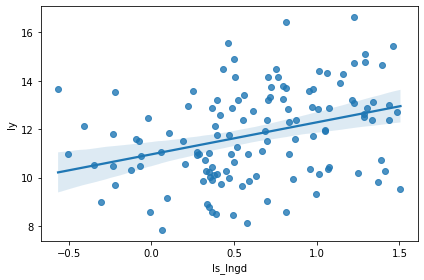

In [ ]:
## Podemos ver os resultados graficamente usando o lm do seaborn
sns.regplot(x="ls_lngd", y="ly", data=dataSolowFinal)

plt.tight_layout()
plt.show()

## Modelo de Solow Aumentado com Capital Humano

In [ ]:
### Modelo irrestrito
## Definindo formula
formula_aumentado_irrestrito = "ly~ ls + lngd + lschool"

## Modelo
mod_aumentado_irrestrito = ols(formula=formula_aumentado_irrestrito, data=dataSolowFinal).fit()

## Sumário
print(mod_aumentado_irrestrito.summary())

# Capital Humano parece dominar os efeitos do capital físico, que se torna insignifcante
# Apesar de ser insignificante, o sinal de lngd vai contra a teoria

                            OLS Regression Results                            
Dep. Variable:                     ly   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     14.59
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           3.40e-08
Time:                        23:01:05   Log-Likelihood:                -244.00
No. Observations:                 128   AIC:                             496.0
Df Residuals:                     124   BIC:                             507.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.0694      2.472      8.927      0.0

In [ ]:
### Modelo com igualdade de coeficientes
## Definindo formula
formula_aumentado_restrito = "ly ~ ls_lngd + lschool_lngd"

## Modelo
mod_aumentado_restrito = ols(formula=formula_aumentado_restrito, data=dataSolowFinal).fit()

## Sumário
print(mod_aumentado_restrito.summary())

## A amostra completa de países resultou em resultado estatisticamente não significantes
## Lembrando da aula passada, os resultados abaixo são próximos a média daqueles obtidos para os 3 grupos de países.

                            OLS Regression Results                            
Dep. Variable:                     ly   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     8.061
Date:                Tue, 07 Dec 2021   Prob (F-statistic):           0.000509
Time:                        23:01:16   Log-Likelihood:                -255.57
No. Observations:                 128   AIC:                             517.1
Df Residuals:                     125   BIC:                             525.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.8815      1.102      9.872   

In [ ]:
## Calculando α (participação do capital físico) implícita
print(f"α Implícito: {np.around(mod_aumentado_restrito.params[1]/(1 + mod_aumentado_restrito.params[1] + mod_aumentado_restrito.params[2]), 2)}")

## Calculando β (participação do capital humano) implícita
print(f"β Implícito: {np.around(mod_aumentado_restrito.params[2]/(1 + mod_aumentado_restrito.params[1] + mod_aumentado_restrito.params[2]), 2)}")

# Valores um pouco menores que os 0.3 que queríamos, mas bem mais perto da realidade do que o modelo tradicional

α Implícito: 0.58
β Implícito: -0.02


# Obrigado!